In [1]:
# %% ------------------------- Cell 1: Imports & Setup ------------------------
import sys
from pathlib import Path
import torch, torch.nn as nn, torch.nn.functional as F
import torchaudio, numpy as np, random
from tqdm.notebook import tqdm

SEED = 0
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)

current_dir = Path.cwd()
repo_root = current_dir.parent.parent
sys.path.insert(0, str(repo_root / "src"))

print("Repo root:", repo_root)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# helper utils
from utils.audio_dataset_loader import (
    load_ears_dataset, load_wham_dataset, load_noizeus_dataset,
    create_audio_pairs, preprocess_audio
)

Repo root: c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85
Using device: cpu


In [2]:
class TinyGRUVAD(nn.Module):
    """Light GRU-based VAD, causal, hearing-aid friendly (~2 k params)."""
    def __init__(self, input_dim=32, hidden_dim=16, dropout=0.1):
        super().__init__()
        # use no right-padding in Conv1d; we'll apply left (causal) padding in forward
        self.pre = nn.Conv1d(input_dim, input_dim, kernel_size=3, padding=0, groups=input_dim)
        self.norm = nn.LayerNorm(input_dim)
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, h=None):
        # x: (B,T,F)
        x = x.transpose(1,2)              # (B,F,T)
        # causal pad: pad (kernel_size-1) frames on the left only so conv doesn't see future frames
        k = self.pre.kernel_size[0] if isinstance(self.pre.kernel_size, (list, tuple)) else self.pre.kernel_size
        pad_left = k - 1
        x = F.pad(x, (pad_left, 0))       # pad on time dimension (left, right)
        x = self.pre(x).transpose(1,2)    # local causal conv
        x = self.norm(x)
        out, h = self.gru(x, h)
        out = self.drop(out)
        # return raw logits (B,T,1); use BCEWithLogitsLoss for stability
        logits = self.fc(out)
        return logits, h


In [3]:
# %% ------------------------- Cell 3: Load Datasets --------------------------
max_pairs = 100
noise_files = load_wham_dataset(repo_root, mode="train", max_files=max_pairs)
clean_files = load_ears_dataset(repo_root, mode="train")
train_pairs = create_audio_pairs(noise_files, clean_files)
print(f"Train pairs: {len(train_pairs)}")

noise_val = load_wham_dataset(repo_root, mode="validation", max_files=20)
clean_val = load_ears_dataset(repo_root, mode="validation")
val_pairs = create_audio_pairs(noise_val, clean_val)
print(f"Val pairs: {len(val_pairs)}")


Limited WHAM dataset to 100 files for train mode


c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85\src\utils\audio_dataset_loader.py:62: UserWarning: torchaudio._backend.utils.info has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  info = torchaudio.info(f)
c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85\.venv\Lib\site-packages\torchaudio\_backend\soundfile_backend.py:120: UserWarning: torchaudio._backend.common.AudioMetaData has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCod

Created 100 audio pairs
Train pairs: 100
Limited WHAM dataset to 20 files for validation mode
Created 20 audio pairs
Val pairs: 20
Created 20 audio pairs
Val pairs: 20


In [4]:
def mix_and_extract(noisy_wave, clean_wave, fs, n_bands=16, frame_len=0.008, hop_len=0.004):
    """log-mel + delta features & frame-wise labels. Return CPU tensors (no device moves).

    IMPORTANT: use center=False in STFT to avoid adding future samples to each frame (causal framing).
    """
    if noisy_wave.dim() > 1: noisy_wave=noisy_wave[0]
    if clean_wave.dim() > 1: clean_wave=clean_wave[0]
    n_fft, hop = int(fs*frame_len), int(fs*hop_len)
    win = torch.hann_window(n_fft)

    def pspec(w): 
        # center=False -> frame does not include future samples relative to the frame end
        spec=torch.stft(w, n_fft, hop, window=win, center=False, return_complex=True)
        return spec.abs()**2

    mel = torchaudio.transforms.MelScale(n_mels=n_bands, sample_rate=fs, n_stft=n_fft//2+1)
    melN = mel(pspec(noisy_wave)).clamp_min(1e-8)
    melC = mel(pspec(clean_wave)).clamp_min(1e-8)
    logN, logC = torch.log(melN.T+1e-8), torch.log(melC.T+1e-8)
    delta=torch.zeros_like(logN); delta[1:]=logN[1:]-logN[:-1]
    feats=torch.cat([logN,delta],1).unsqueeze(0)
    ratio=melC.T.sum(1)/(melN.T.sum(1)+1e-8)
    labels=(ratio>0.2).float().unsqueeze(1).unsqueeze(0)
    return feats, labels


In [5]:

# %% ------------------------- Cell 5: Dataset & Loader -----------------------
class LiveMixDataset(torch.utils.data.Dataset):
    def __init__(self,pairs,target_sr=16_000,snr_range=(-5,10)):
        self.pairs=pairs; self.sr=target_sr; self.range=snr_range
    def __len__(self): return len(self.pairs)
    def __getitem__(self,idx):
        n,c=self.pairs[idx]; snr=random.uniform(*self.range)
        cw,nw,noisy,fs=preprocess_audio(Path(c),Path(n),self.sr,snr,None)
        feats,labs=mix_and_extract(noisy,cw,fs)
        return feats.squeeze(0),labs.squeeze(0)

def collate_pad(batch):
    feats,labs=zip(*batch); L=[f.size(0) for f in feats]; Tmax=max(L); Fdim=feats[0].size(1)
    X=torch.zeros(len(batch),Tmax,Fdim); Y=torch.zeros(len(batch),Tmax,1)
    for i,(f,l) in enumerate(zip(feats,labs)): X[i,:f.size(0)]=f; Y[i,:l.size(0)]=l
    return X,Y,torch.tensor(L)

train_ds=LiveMixDataset(train_pairs)
val_ds=LiveMixDataset(val_pairs)
train_dl=torch.utils.data.DataLoader(train_ds,batch_size=8,shuffle=True,collate_fn=collate_pad,pin_memory=True)
val_dl=torch.utils.data.DataLoader(val_ds,batch_size=8,collate_fn=collate_pad,pin_memory=True)


Epoch 50/50  TL=0.493  VL=0.512  PREC=0.865  REC=0.659  F1=0.748  AUC=0.821  [INFO] new best (F1=0.748)


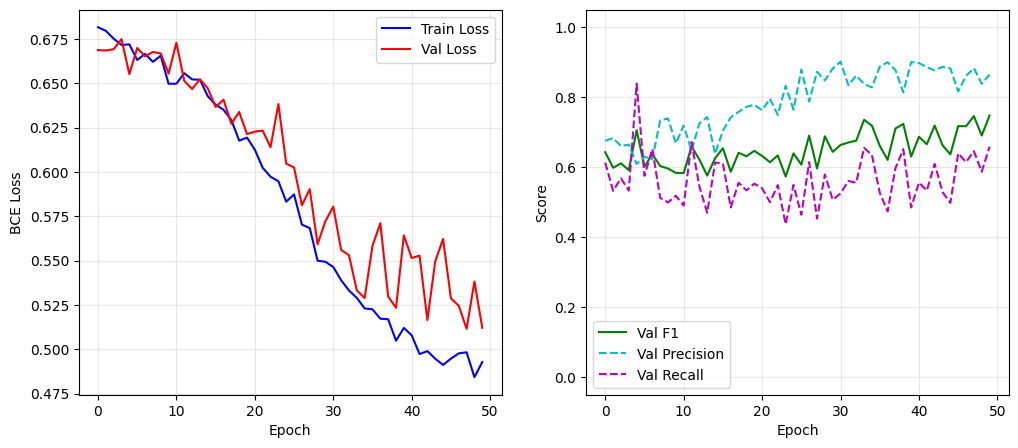

Loaded best model (F1=0.748)


In [6]:
# %% ------------------------- Cell 6: Training (clean live view) -------------------------------
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

vad = TinyGRUVAD(32, 16).to(device)
opt = torch.optim.AdamW(vad.parameters(), lr=1e-3, weight_decay=1e-6)
crit = nn.BCEWithLogitsLoss(reduction='sum')  # we'll average by valid frames
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=3)

bestF1, bestPath = -1.0, repo_root / "models" / "tiny_vad_best.pth"
bestPath.parent.mkdir(parents=True, exist_ok=True)

# prepare live plot
plt.ion()
fig, (ax_loss, ax_f1) = plt.subplots(1, 2, figsize=(12, 5))
ax_loss.set_title("Loss"); ax_f1.set_title("Validation F1 / Precision / Recall")
ax_loss.set_xlabel("Epoch"); ax_f1.set_xlabel("Epoch")
ax_loss.set_ylabel("BCE Loss"); ax_f1.set_ylabel("Score")
ax_loss.grid(True, alpha=0.3); ax_f1.grid(True, alpha=0.3)
train_losses, val_losses, f1_scores, prec_scores, rec_scores = [], [], [], [], []

for epoch in range(1, 51):
    # ---------------- Train ----------------
    vad.train(); Ltr = 0.0
    for x, y, L in tqdm(train_dl, desc=f"Epoch {epoch}/50", leave=False):
        x, y = x.to(device), y.to(device)
        # x: (B,T,F), y: (B,T,1), L: (B,)
        logits, _ = vad(x)
        # mask padded frames using lengths
        B, Tmax = logits.size(0), logits.size(1)
        mask = (torch.arange(Tmax, device=L.device)[None, :] < L[:, None]).to(device)
        logits_flat = logits.squeeze(-1)[mask]
        labels_flat = y.squeeze(-1)[mask]
        loss = crit(logits_flat, labels_flat) / mask.sum().clamp_min(1.0)
        opt.zero_grad(); loss.backward(); opt.step()
        Ltr += loss.item()
    Ltr /= len(train_dl)
    train_losses.append(Ltr)

    # ---------------- Validate ----------------
    vad.eval(); Lval = 0.0; P, L = [], []
    with torch.no_grad():
        for x, y, lengths in val_dl:
            x, y = x.to(device), y.to(device)
            logits, _ = vad(x)
            # masked validation loss (sum over frames) / n_valid_frames
            B, Tmax = logits.size(0), logits.size(1)
            mask = (torch.arange(Tmax, device=lengths.device)[None, :] < lengths[:, None]).to(device)
            logits_flat = logits.squeeze(-1)[mask]
            labels_flat = y.squeeze(-1)[mask]
            Lval += (nn.functional.binary_cross_entropy_with_logits(logits_flat, labels_flat, reduction='sum') / mask.sum().clamp_min(1.0)).item()
            probs = torch.sigmoid(logits).cpu().numpy()
            labs = y.cpu().numpy()
            # append per-frame valid frames to lists
            for b in range(B):
                valid = slice(0, int(lengths[b].item()))
                P.append(probs[b, valid].ravel()); L.append(labs[b, valid].ravel())
    Lval /= len(val_dl)
    val_losses.append(Lval)

    probs, labels = np.concatenate(P), np.concatenate(L).astype(int)
    pred = (probs >= 0.5).astype(int)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, pred, average="binary", zero_division=0)
    auc = roc_auc_score(labels, probs)
    f1_scores.append(f1)
    prec_scores.append(prec)
    rec_scores.append(rec)
    sched.step(Lval)

    # ---------------- Save & Display ----------------
    if f1 > bestF1:
        bestF1 = f1
        torch.save(vad.state_dict(), bestPath)
        status = f"[INFO] new best (F1={f1:.3f})"
    else:
        status = ""

    clear_output(wait=True)           # <-- clear console output
    print(f"Epoch {epoch}/50  TL={Ltr:.3f}  VL={Lval:.3f}  PREC={prec:.3f}  REC={rec:.3f}  F1={f1:.3f}  AUC={auc:.3f}  {status}")

    # update live plots
    ax_loss.cla(); ax_f1.cla()
    ax_loss.plot(train_losses, "b-", label="Train Loss")
    ax_loss.plot(val_losses, "r-", label="Val Loss")
    ax_loss.legend(); ax_loss.set_xlabel("Epoch"); ax_loss.set_ylabel("BCE Loss"); ax_loss.grid(True)

    ax_f1.plot(f1_scores, "g-", label="Val F1")
    ax_f1.plot(prec_scores, "c--", label="Val Precision")
    ax_f1.plot(rec_scores, "m--", label="Val Recall")
    ax_f1.legend(); ax_f1.set_xlabel("Epoch"); ax_f1.set_ylabel("Score")
    ax_f1.set_ylim(-0.05, 1.05); ax_f1.grid(True)

    display(fig)
    plt.pause(0.001)

    if sched._last_lr[0] < 1e-5: 
        print("[INFO] Early stop (triggered by LR floor)")
        break

plt.ioff()
vad.load_state_dict(torch.load(bestPath, map_location=device))
print(f"Loaded best model (F1={bestF1:.3f})")


Clean speech duration: 16.75s (267937 samples)
Noise duration: 15.02s (240293 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades


c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85\.venv\Lib\site-packages\torchaudio\_backend\utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


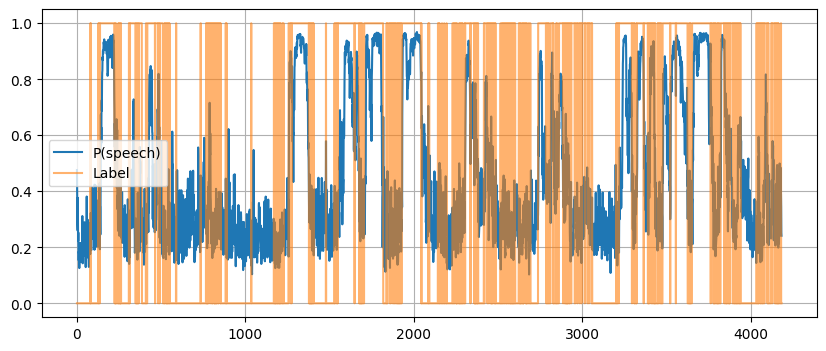

In [7]:

# %% ------------------------- Cell 8: Quick Validation Plot ------------------
import matplotlib.pyplot as plt
exN,exC=val_pairs[0]
cw,nw,noisy,fs=preprocess_audio(Path(exC),Path(exN),16_000,0)
# use 8 ms frames with 4 ms hop for the digital filter timing
f,l=mix_and_extract(noisy,cw,fs,frame_len=0.008, hop_len=0.004)
vad.eval(); 
with torch.no_grad():
    logits,_=vad(f.to(device))
    p=torch.sigmoid(logits).squeeze().cpu().numpy()
    l=l.squeeze().cpu().numpy()
plt.figure(figsize=(10,4))
plt.plot(p,label="P(speech)"); plt.plot(l,label="Label",alpha=.6); plt.legend(); plt.grid(); plt.show()


# Integration with Wiener Filter

Now that we have a trained TinyGRUVAD model, we can use it to replace the traditional energy-based VAD in the Wiener filter!

## How It Works:
1. **TinyGRUVAD** predicts speech/non-speech for each frame using mel features
2. **Wiener Filter** uses these predictions to update noise estimates
3. Non-speech frames → update noise model
4. Speech frames → apply Wiener gain without updating noise

This gives better noise tracking, especially for non-stationary noise!

In [8]:
# %% ------------------------- Cell 9: Load Integration Module --------------------------
from tiny_vad_integration import wiener_filter_with_tiny_vad

# Test on a sample noisy audio file
test_noise, test_clean = val_pairs[0]
clean_wav, noise_wav, noisy_wav, fs = preprocess_audio(
    Path(test_clean), 
    Path(test_noise), 
    16000, 
    snr_db=5.0
)

print(f"Testing Wiener filter with TinyGRUVAD...")
print(f"Input audio: {noisy_wav.shape[0]/fs:.2f}s at {fs}Hz")

# Apply Wiener filter with TinyGRUVAD
enhanced, _ = wiener_filter_with_tiny_vad(
    noisy_audio=noisy_wav,
    fs=fs,
    vad_model_path=bestPath,
    vad_threshold=0.5,
    frame_dur_ms=8,
    output_dir=repo_root / "results" / "tiny_vad_wiener",
    output_file="enhanced",
    input_name="test_sample",
)

print("✓ Enhanced audio generated!")
print(f"  Output shape: {enhanced.shape}")
print(f"  Saved to: results/tiny_vad_wiener/")


Clean speech duration: 16.75s (267937 samples)
Noise duration: 15.02s (240293 samples)
Noise extended using overlap-crossfade method with 800-sample crossfades
Testing Wiener filter with TinyGRUVAD...
Input audio: 16.75s at 16000Hz
Using device: cpu
TinyGRUVAD loaded from c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85\models\tiny_vad_best.pth
Device: cpu

Computing VAD predictions...
VAD: 1946/4185 frames detected as speech (46.5%)

Applying Wiener filter...

Enhanced audio saved to: c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85\results\tiny_vad_wiener\enhanced_test_sample_FRAME8ms_MU0p980_ADD0p980_TinyVAD0p50.wav
✓ Enhanced audio generated!
  Output shape: torch.Size([267904])
  Saved to: results/tiny_vad_wiener/

Enhanced audio saved to: c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85\results\tiny_vad_wiener\enhanced_test_sample_FRAME8ms_MU0p980_ADD0p980_TinyVAD0p50.wav
✓ Enhan

c:\Users\kapun_63wn2un\Documents\ELEN4012 - Investigation\Repository\PROJECT-25P85\.venv\Lib\site-packages\torchaudio\_backend\utils.py:337: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.save_with_torchcodec` under the hood. Some parameters like format, encoding, bits_per_sample, buffer_size, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's encoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.encoders.AudioEncoder
  warnings.warn(


In [9]:
# %% ------------------------- Cell 10: Compare Audio --------------------------
import IPython.display as ipd
import matplotlib.pyplot as plt

# Plot comparison
fig, axes = plt.subplots(3, 1, figsize=(14, 8))

time_axis = np.arange(len(noisy_wav)) / fs

axes[0].plot(time_axis, noisy_wav.numpy(), 'r', alpha=0.7)
axes[0].set_title('Noisy Speech (SNR = 5dB)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)

axes[1].plot(time_axis, enhanced.numpy(), 'b', alpha=0.7)
axes[1].set_title('Enhanced Speech (Wiener + TinyGRUVAD)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Amplitude')
axes[1].grid(True, alpha=0.3)

axes[2].plot(time_axis, clean_wav.numpy(), 'g', alpha=0.7)
axes[2].set_title('Clean Speech (Reference)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Amplitude')
axes[2].set_xlabel('Time (s)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Play audio samples
print("🔊 Listen to the results:")
print("\n1. Noisy speech:")
display(ipd.Audio(noisy_wav.numpy(), rate=fs))

print("\n2. Enhanced speech (Wiener + TinyGRUVAD):")
display(ipd.Audio(enhanced.numpy(), rate=fs))

print("\n3. Clean speech (reference):")
display(ipd.Audio(clean_wav.numpy(), rate=fs))


ValueError: x and y must have same first dimension, but have shapes (267937,) and (267904,)